### Setup and data loading

The data from simulations is stored in parquet files for efficient memory storage. This allows us to query the data using SQL as we would in any relational database.

This notebook uses DuckDB to query Parquet event and grid datasets under 

This notebook uses DuckDB to query Parquet event datasets under `results_parquet/events/` and `results_parquet/grids` respectively. This infrastructure allows us to query without loading all the data into memory. If DuckDB isn't installed, please `pip install duckdb`.

In [ ]:
# Logging + Tee setup (mirrors outputs to rotating log)
import os, sys
from pathlib import Path
from datetime import datetime
import logging
from logging.handlers import RotatingFileHandler

# Create logs directory and timestamped log path
LOGS_DIR = Path('logs')
LOGS_DIR.mkdir(parents=True, exist_ok=True)
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
ANALYSIS_LOG_PATH = LOGS_DIR / f'analysis_{ts}.log'

# Reduce buffering and ensure child processes are unbuffered
for s in (sys.stdout, sys.stderr):
    try:
        s.reconfigure(line_buffering=True)
    except Exception:
        pass
os.environ['PYTHONUNBUFFERED'] = '1'

# Configure logging to console (stderr) + rotating file
root_logger = logging.getLogger()
for h in list(root_logger.handlers):
    root_logger.removeHandler(h)
fmt = logging.Formatter(
    fmt='%(asctime)s | %(levelname)-8s | %(name)s | %(module)s:%(lineno)d | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
console_h = logging.StreamHandler(sys.stderr)
console_h.setLevel(logging.INFO)
console_h.setFormatter(fmt)
file_h = RotatingFileHandler(ANALYSIS_LOG_PATH, maxBytes=50*1024*1024, backupCount=3, encoding='utf-8')
file_h.setLevel(logging.DEBUG)
file_h.setFormatter(fmt)
logging.basicConfig(level=logging.DEBUG, handlers=[console_h, file_h], force=True)
analysis_logger = logging.getLogger('analysis')

# Tee stdout/stderr to the same log file (idempotent)
if not globals().get('ANALYSIS_TEE_ACTIVE', False):
    import io
    ANALYSIS_ORIG_STDOUT = sys.stdout
    ANALYSIS_ORIG_STDERR = sys.stderr
    ANALYSIS_LOG_FP = open(ANALYSIS_LOG_PATH, 'a', encoding='utf-8', buffering=1)  # line-buffered

    class Tee(io.TextIOBase):
        def __init__(self, primary, secondary):
            self.primary = primary
            self.secondary = secondary
        def write(self, s):
            try: self.primary.write(s)
            except Exception: pass
            try: self.secondary.write(s)
            except Exception: pass
            try: self.flush()
            except Exception: pass
            return len(s)
        def flush(self):
            try: self.primary.flush()
            except Exception: pass
            try: self.secondary.flush()
            except Exception: pass
        def isatty(self):
            try: return self.primary.isatty()
            except Exception: return False
        def fileno(self):
            if hasattr(self.primary, 'fileno'):
                try: return self.primary.fileno()
                except Exception: pass
            raise OSError('fileno not available')

    sys.stdout = Tee(ANALYSIS_ORIG_STDOUT, ANALYSIS_LOG_FP)
    sys.stderr = Tee(ANALYSIS_ORIG_STDERR, ANALYSIS_LOG_FP)
    ANALYSIS_TEE_ACTIVE = True

print(f'Analysis log file: {ANALYSIS_LOG_PATH}')
print("To follow logs live, run in terminal:")
print(f"tail -f '{ANALYSIS_LOG_PATH}'")
analysis_logger.info('Analysis logging initialized.')

In [2]:
# print all files in the current working directory
import os
import glob
print(os.listdir('.'))

from pathlib import Path

current_dir = Path('.')

directories = sorted([p for p in (current_dir / 'results_parquet/events').glob('**/grid_id*') if p.is_dir()])

# print number of found grid id partitions
print(f"Found {len(directories)} grid id partitions")

In [3]:
# Imports and display config
import os, sys, json, math
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Optional plotting enhancements
try:
    import seaborn as sns
    sns.set_theme()
except Exception:
    sns = None

# DuckDB for fast, low-memory Parquet scans
# use the previous list of files

try:
    import duckdb
    HAVE_DUCKDB = True
except Exception:
    HAVE_DUCKDB = False
    # Change to read from the specified folder
    BASE_RESULTS = Path('results_parquet')
    EVENT_DATASETS = [BASE_RESULTS / 'events'] if (BASE_RESULTS / 'events').is_dir() else []
    if not EVENT_DATASETS:
        raise FileNotFoundError("No 'events' datasets found under the specified path.")
    events_dir = EVENT_DATASETS[0]  # Use the single events directory
    base_parquet_dir = events_dir.parent
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 140)

# Discover event-level Parquet datasets under results/**/parquet/events
BASE_RESULTS = Path('results_parquet')
directories = sorted([p for p in (current_dir / 'results_parquet/events').glob('**/grid_id*') if p.is_dir()])
if not directories:
    raise FileNotFoundError("No 'events' datasets found under results_parquet/**/parquet/")

# Establish a DuckDB connection and create an 'events' view
if not HAVE_DUCKDB:
    raise RuntimeError('DuckDB not installed; please `pip install duckdb` for low-memory analysis.')
con = duckdb.connect()
# Optional: cap DuckDB memory usage to avoid OOM (adjust as needed)
try:
    con.execute("SET memory_limit='1GB'")
except Exception:
    pass
events_dir = BASE_RESULTS / 'events'
pat = str(events_dir / '**/*.parquet')
con.execute(f"CREATE OR REPLACE VIEW events AS SELECT * FROM read_parquet('{pat}')")
# Inspect available columns once for conditional logic later and sort for consistency
# also include the grid ID in the events view
cols = sorted([d[0] for d in con.execute(f"SELECT * FROM read_parquet('{pat}') LIMIT 1").description])
print('Columns available:', cols)


### Phases of the Experiment

The experiment proceeds in four distinct phases, each tied to the theoretical guarantees of the Memory Pair framework.


#### 1. Calibration

We first verify theoretical properties of the data stream using a constant 500 steps to measure stream properties. Constants such as the Lipschitz bound $G$, domain diameter $D$, and curvature spectrum $(c, C)$ are estimated to ensure the strong convexity assumption:

$$
f(y) \;\geq\; f(x) + \nabla f(x)^\top (y - x) + \frac{\lambda}{2}\|y - x\|^2.
$$

This ensures that regret bounds and capacity formulas derived later are valid.

---

#### 2. Warmup

During warmup, the learner collects enough samples to reach the **sample complexity threshold** $N_\gamma$. This is the minimum horizon such that the average regret drops below a target $\gamma$:

$$
\frac{1}{N} R_N \;\leq\; \gamma, \qquad 
R_N := \sum_{t=1}^N \bigl(\ell_t(w_t) - \ell_t(w^\star)\bigr).
$$

Only after $N_\gamma$ events does the deferred inference gate open, ensuring predictions are **PAC-competitive from the start**.

---

#### 3. Workload

In the workload phase, the model processes an interleaved stream of **insert** and **delete** events:
$$
E_t \in \{\text{insert}(x_t, y_t), \text{delete}(u_t)\}.
$$

- Insertions update the model via quasi-Newton (L-BFGS) steps.  
- Deletions trigger symmetric unlearning steps, consuming from the **deletion-capacity odometer**.

Dynamic regret is bounded by both a static term and a drift-dependent path-length term:

$$
R^{\text{dyn}}_T = O\!\left(\frac{G^2}{\lambda}\ln T \;+\; G P_T\right),
\quad
P_T = \sum_{t=2}^T \|w_t^\star - w_{t-1}^\star\|_2.
$$

---

#### 4. Finalization

At the conclusion of the workload, we finalize the **odometer** and check whether deletion capacity $m$ was respected:

$$
m \;\leq\; \frac{\gamma N - GD\sqrt{cC S_N}}{G \sigma_{\text{step}} \sqrt{2 \ln(1/\delta_B)}},
\quad
S_N = \sum_{t=1}^N \|g_t\|^2.
$$

If $m$ has been exhausted, the model must be retrained to preserve accuracy and fidelity guarantees.


In [4]:
# group events by grid_id and operation, counting occurrences
event_counts = con.execute("""
SELECT grid_id, op, COUNT(*) AS count
FROM events
GROUP BY grid_id, op
ORDER BY grid_id, op
""").df()

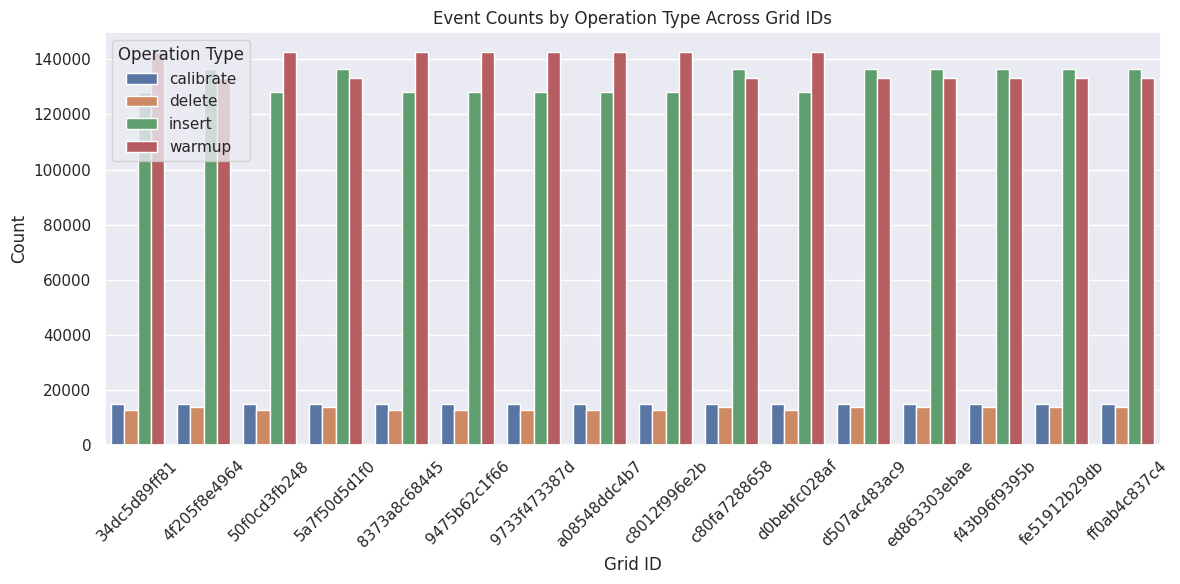

In [5]:
# visualize the count of each operation type across different grid IDs
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=event_counts, x='grid_id', y='count', hue='op')
plt.title('Event Counts by Operation Type Across Grid IDs')
plt.xlabel('Grid ID')
plt.ylabel('Count')
plt.legend(title='Operation Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

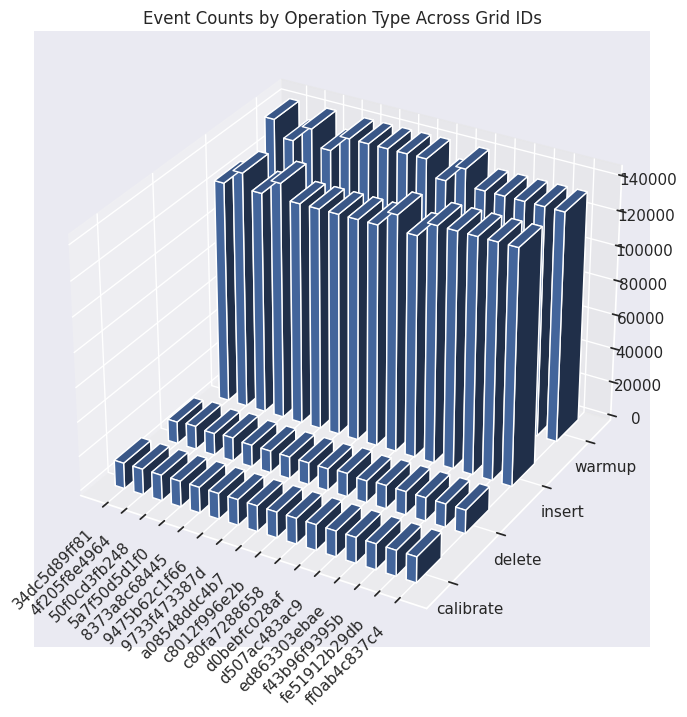

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Prepare pivot table
pivot_df = event_counts.pivot(index='grid_id', columns='op', values='count').fillna(0)

# Get coordinates
xpos, ypos = np.meshgrid(np.arange(len(pivot_df.index)), np.arange(len(pivot_df.columns)))
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

# Heights are the counts
dz = pivot_df.values.T.flatten()

# Bar dimensions
dx = dy = 0.5

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)

# Labeling
ax.set_xticks(np.arange(len(pivot_df.index)) + dx/2)
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')
ax.set_yticks(np.arange(len(pivot_df.columns)) + dy/2)
ax.set_yticklabels(pivot_df.columns)
ax.set_title('Event Counts by Operation Type Across Grid IDs')

plt.show()


### Analyzing the Distributions of Operation Counts Across Grid IDs

When I look at the graph above I notice an interesting trend. The sample complexities are largely consistent for many of the grid cells. Calibration is firmly set to 1500 steps and so this makes sense, but that isn't necessarily the case for other phases of the experiment.

The number of `warmup` steps falls into two regimes of almost discrete values. The same can be said of the `insert` and `delete` steps, as well. I wonder whether this would suggest a degree of consistency that isn't exactly intentional.

I'd like to see how consistent the parameters are across these cells. If the parameters for the sample complexity are exactly the same then I could understand some overlap in the values. Otherwise, I'm afraid we might be duplicating regret values. Or maybe some of the parameter variations aren't effective. I'd like to explore this further.

In [7]:
summary = (
    event_counts.groupby("op")["count"]
    .agg(["nunique", "min", "max"])
    .reset_index()
)
print(summary)

# Also see the actual unique values per op
unique_vals = event_counts.groupby("op")["count"].unique()
print(unique_vals)


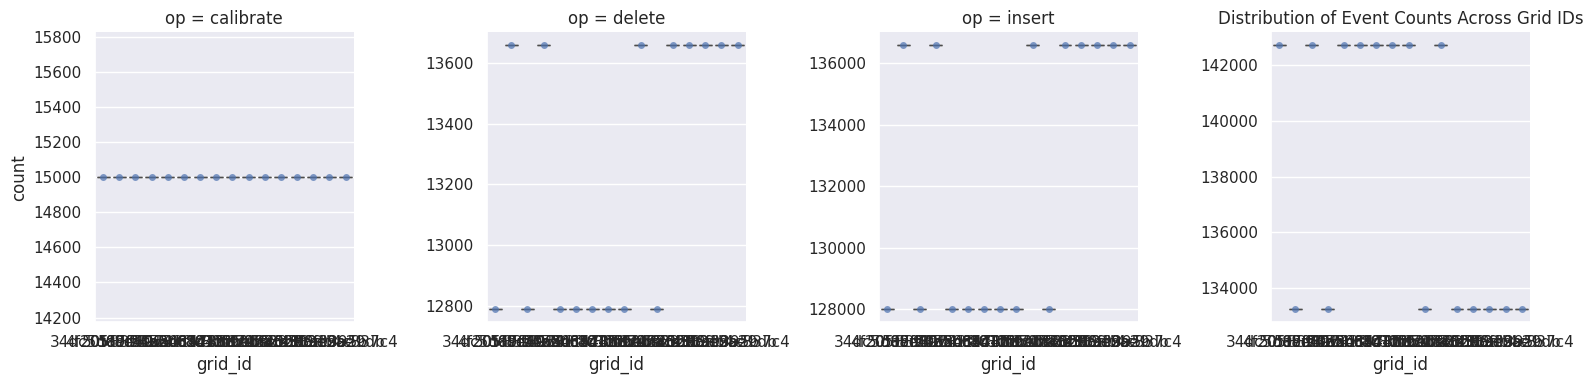

In [8]:
# make one plot per operation type 

import seaborn as sns
g = sns.FacetGrid(event_counts, col="op", col_wrap=4, sharey=False, height=4)
g.map(sns.stripplot, "grid_id", "count", jitter=True, alpha=0.7)
g.map(sns.boxplot, "grid_id", "count", showcaps=False, boxprops={'facecolor':'None'})
plt.title("Distribution of Event Counts Across Grid IDs")
plt.show()


In [9]:
# Load grid parameters from results_parquet/grids and register as a DuckDB view
from pathlib import Path

BASE_RESULTS = Path('results_parquet')
grids_root = BASE_RESULTS / 'grids'

# Prefer Parquet if available; otherwise fall back to params.json files
grid_parquet_files = list(grids_root.rglob('*.parquet')) if grids_root.exists() else []
if grid_parquet_files:
    pat_grids = str(grids_root / '**/*.parquet')
    grids_df = con.execute(f"SELECT * FROM read_parquet('{pat_grids}')").df()
else:
    rows = []
    if grids_root.exists():
        for params_path in grids_root.rglob('params.json'):
            try:
                # Extract grid_id from folder name like grid_id=<ID>
                parent_name = params_path.parent.name
                gid = parent_name.split('=', 1)[1] if 'grid_id=' in parent_name else parent_name
                with open(params_path, 'r') as f:
                    params = json.load(f)
                params['grid_id'] = gid
                rows.append(params)
            except Exception:
                continue
    grids_df = pd.DataFrame(rows)

# Keep a canonical name used elsewhere
params_df = grids_df.copy()

# Make available to SQL for joins
try:
    con.unregister('grids_df')
except Exception:
    pass
if not params_df.empty:
    con.register('grids_df', params_df)
    con.execute('CREATE OR REPLACE VIEW grids AS SELECT * FROM grids_df')

print('grids/params_df shape:', params_df.shape)
params_df.head()

,C_hat,D_bound,D_cap,D_hat,G_hat,accountant,adagrad_eps,adaptive_geometry,adaptive_privacy,algo,alphas,bootstrap_iters,c_hat,comparator,d_max,dataset,delete_ratio,delta_b,delta_total,disable_regret_gate,drift_adaptation,drift_kappa,drift_mode,drift_rate,drift_threshold,drift_window,dynamic_comparator,ema_beta,enable_oracle,enforce_nonnegative_regret,eps_total,eta_max,gamma_bar,gamma_split,grid_id,hessian_clamp_eps,lambda_,lambda_cap,lambda_est_beta,lambda_est_bounds,lambda_floor,lambda_min_threshold,lambda_reg,lambda_stability_K,lambda_stability_min_steps,m_max,max_events,online_standardize,output_granularity,pair_admission_m,parquet_only_mode,parquet_out,quantile,recal_threshold,recal_window,regret_comparator_mode,regret_warmup_threshold,relaxation_factor,rho_total,rotate_angle,sens_calib,strong_convexity,target_C,target_D,target_G,target_PT,target_ST,target_c,target_lambda,trim_quantile,window_erm
0,None,2.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",500,None,dynamic,inf,synthetic,10.0,0.10,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,False,True,1.0,1.0,0.9,0.5,9475b62c1f66,0.0,0.05,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.05,100,100,8,10000,False,seed,0.000001,True,results_parquet,0.95,0.3,None,oracle,None,0.8,1.0,0.01,50,False,20.0,2.0,2.0,30.0,200000.0,0.05,0.05,0.95,False
1,None,2.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",500,None,dynamic,inf,synthetic,10.0,0.10,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,False,True,1.0,1.0,0.9,0.5,4f205f8e4964,0.0,0.05,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.01,100,100,8,10000,False,seed,0.000001,True,results_parquet,0.95,0.3,None,oracle,None,0.8,1.5,0.01,50,False,20.0,2.0,2.0,30.0,200000.0,0.05,0.05,0.95,False
2,None,2.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",500,None,dynamic,inf,synthetic,10.0,0.10,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,False,True,1.0,1.0,0.9,0.5,c8012f996e2b,0.0,0.10,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.05,100,100,8,10000,False,seed,0.000001,True,results_parquet,0.95,0.3,None,oracle,None,0.8,1.0,0.01,50,False,20.0,2.0,2.0,30.0,200000.0,0.05,0.05,0.95,False
3,None,2.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",500,None,dynamic,inf,synthetic,10.0,0.05,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,False,True,1.0,1.0,0.9,0.5,ed863303ebae,0.0,0.05,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.01,100,100,8,10000,False,seed,0.000001,True,results_parquet,0.95,0.3,None,oracle,None,0.8,1.5,0.01,50,False,20.0,2.0,2.0,30.0,200000.0,0.05,0.05,0.95,False
4,None,2.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",500,None,dynamic,inf,synthetic,10.0,0.05,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,False,True,1.0,1.0,0.9,0.5,34dc5d89ff81,0.0,0.10,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.05,100,100,8,10000,False,seed,0.000001,True,results_parquet,0.95,0.3,None,oracle,None,0.8,1.5,0.01,50,False,20.0,2.0,2.0,30.0,200000.0,0.05,0.05,0.95,False


In [10]:
# Merge event counts with grid params (params_df)
if 'params_df' in globals() and not params_df.empty:
    merged = event_counts.merge(params_df, on="grid_id", how='left')
    # Example: compare warmup counts by gamma_bar if present
    if 'gamma_bar' in merged.columns:
        merged[merged["op"] == "warmup"].groupby("gamma_bar")["count"].unique()
    else:
        print("Column 'gamma_bar' not found in params; showing merged head.")
        merged.head()
else:
    print("params_df is empty or undefined; skipping merge preview.")

In [ ]:
# Example: compare warmup counts by gamma_bar
merged.groupby("gamma_bar")["count"].unique()


In [12]:
# Minimal peek at a few rows for schema intuition (safe LIMIT)
peek = con.execute("SELECT * FROM events WHERE event_type not in ('calibrate', 'warmup') LIMIT 5").df()
print('Peek at events (5 rows):')
peek


,event_type,event,op,regret,acc,accountant_type,eps_spent,capacity_remaining,sigma_step_theory,sample_id,event_id,segment_id,x_norm,delta_P,w_star_norm,noise,theory_targets,G_hat,D_hat,c_hat,C_hat_1,P_T_true,g_norm,clip_applied,ST_running,PT_target_residual,ST_target_residual,sigma_step,privacy_spend_running,S_scalar,eta_t,lambda_est,eps_step_theory,delta_step_theory,rho_step,P_T,comparator_type,drift_flag,regret_dynamic,regret_static_term,regret_path_term,sens_delete,P_T_est,drift_boost_remaining,base_eta_t,regret_increment,cum_regret,avg_regret,noise_regret_increment,noise_regret_cum,cum_regret_with_noise,avg_regret_with_noise,N_gamma,rho_spent,deletion_capacity,rho_total,lambda_raw,sc_stable,pair_admitted,pair_damped,d_norm,sc_active,static_regret_increment,path_regret_increment,accountant,m_capacity,m_used,eps_remaining,rho_remaining,delta_total,stepsize_policy,stepsize_params,sigma_delete,grid_id,seed
0,insert,1627,insert,0.381675,1.113290,None,NaN,NaN,231.906753,theory_001624,1624,0,8.944272,0.00311,1.0,0.058746,<NA>,2.0,2.0,0.05,20.0,4.951111,0.017888,False,163.769334,0.002537,-0.994961,231.906753,0.0,517517.501965,0.002780,79.736245,<NA>,<NA>,1.5,0.0,none,False,0.0,0.0,0.0,<NA>,0.0,0,0.002780,0.381675,1730.443159,1.096605,0.0,0.0,1730.443159,1.096605,874.0,0.0,1,1.5,79.868786,1578,True,False,0.124928,False,0.0,0.0,zcdp,1,0,<NA>,1.5,0.00001,adagrad,"{'D': 2.0, 'S_t': 517517.50196493923, 'eta_for...",NaN,34dc5d89ff81,0
1,insert,1628,insert,8.130382,4.034709,None,NaN,NaN,231.906753,theory_001625,1625,0,8.944272,0.00311,1.0,-0.090326,<NA>,2.0,2.0,0.05,20.0,4.954221,0.017888,False,163.769654,0.002541,-0.994964,231.906753,0.0,518828.761736,0.002777,79.739521,<NA>,<NA>,1.5,0.0,none,False,0.0,0.0,0.0,<NA>,0.0,0,0.002777,8.130382,1738.573541,1.101060,0.0,0.0,1738.573541,1.101060,874.0,0.0,1,1.5,79.769002,1579,True,False,0.459410,False,0.0,0.0,zcdp,1,0,<NA>,1.5,0.00001,adagrad,"{'D': 2.0, 'S_t': 518828.761736076, 'eta_formu...",NaN,34dc5d89ff81,0
2,insert,1629,insert,1.889729,1.945663,None,NaN,NaN,231.906753,theory_001626,1626,0,8.944271,0.00311,1.0,0.073250,<NA>,2.0,2.0,0.05,20.0,4.957330,0.017888,False,163.769974,0.002544,-0.994967,231.906753,0.0,519133.717480,0.002776,79.752793,<NA>,<NA>,1.5,0.0,none,False,0.0,0.0,0.0,<NA>,0.0,0,0.002776,1.889729,1740.463270,1.101559,0.0,0.0,1740.463270,1.101559,874.0,0.0,1,1.5,79.872239,1580,True,False,0.221028,False,0.0,0.0,zcdp,1,0,<NA>,1.5,0.00001,adagrad,"{'D': 2.0, 'S_t': 519133.7174796808, 'eta_form...",NaN,34dc5d89ff81,0
3,insert,1630,insert,4.663449,3.157383,None,NaN,NaN,231.906753,theory_001627,1627,0,8.944272,0.00311,1.0,-0.037596,<NA>,2.0,2.0,0.05,20.0,4.960440,0.017888,False,163.770294,0.002548,-0.994970,231.906753,0.0,519936.380063,0.002774,79.763191,<NA>,<NA>,1.5,0.0,none,False,0.0,0.0,0.0,<NA>,0.0,0,0.002774,4.663449,1745.126719,1.103812,0.0,0.0,1745.126719,1.103812,874.0,0.0,1,1.5,79.856778,1581,True,False,0.349840,False,0.0,0.0,zcdp,1,0,<NA>,1.5,0.00001,adagrad,"{'D': 2.0, 'S_t': 519936.38006293523, 'eta_for...",NaN,34dc5d89ff81,0
4,insert,1631,insert,0.657120,1.163289,None,NaN,NaN,231.906753,theory_001628,1628,0,8.944272,0.00311,1.0,0.222960,<NA>,2.0,2.0,0.05,20.0,4.963550,0.017888,False,163.770614,0.002552,-0.994973,231.906753,0.0,520045.350809,0.002773,79.782265,<NA>,<NA>,1.5,0.0,none,False,0.0,0.0,0.0,<NA>,0.0,0,0.002773,0.657120,1745.783839,1.103530,0.0,0.0,1745.783839,1.103530,874.0,0.0,1,1.5,79.953934,1582,True,False,0.129068,False,0.0,0.0,zcdp,1,0,<NA>,1.5,0.00001,adagrad,"{'D': 2.0, 'S_t': 520045.35080856207, 'eta_for...",NaN,34dc5d89ff81,0


In [13]:
# Load grid parameters from grids/grid_id=*/params.json (small)
def load_grid_params(base_parquet_dir: Path) -> pd.DataFrame:
    grids_root = base_parquet_dir / 'grids'
    rows = []
    if not grids_root.exists():
        return pd.DataFrame()
    for params_path in grids_root.rglob('params.json'):
        try:
            gid = params_path.parent.name.split('=',1)[1]
            with open(params_path, 'r') as f:
                params = json.load(f)
            params['grid_id'] = gid
            rows.append(params)
        except Exception:
            continue
    if not rows:
        return pd.DataFrame()
    return pd.DataFrame(rows)

params_df = load_grid_params(Path('results_parquet'))
print('params_df:', params_df.shape)
params_df.head(3)


,C_hat,D_bound,D_cap,D_hat,G_hat,accountant,adagrad_eps,adaptive_geometry,adaptive_privacy,algo,alphas,bootstrap_iters,c_hat,comparator,d_max,dataset,delete_ratio,delta_b,delta_total,disable_regret_gate,drift_adaptation,drift_kappa,drift_mode,drift_rate,drift_threshold,drift_window,dynamic_comparator,ema_beta,enable_oracle,enforce_nonnegative_regret,eps_total,eta_max,gamma_bar,gamma_split,grid_id,hessian_clamp_eps,lambda_,lambda_cap,lambda_est_beta,lambda_est_bounds,lambda_floor,lambda_min_threshold,lambda_reg,lambda_stability_K,lambda_stability_min_steps,m_max,max_events,online_standardize,output_granularity,pair_admission_m,parquet_only_mode,parquet_out,quantile,recal_threshold,recal_window,regret_comparator_mode,regret_warmup_threshold,relaxation_factor,rho_total,rotate_angle,sens_calib,strong_convexity,target_C,target_D,target_G,target_PT,target_ST,target_c,target_lambda,trim_quantile,window_erm
0,None,2.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",500,None,dynamic,inf,synthetic,10.0,0.1,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,False,True,1.0,1.0,0.9,0.5,9475b62c1f66,0.0,0.05,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.05,100,100,8,10000,False,seed,0.000001,True,results_parquet,0.95,0.3,None,oracle,None,0.8,1.0,0.01,50,False,20.0,2.0,2.0,30.0,200000.0,0.05,0.05,0.95,False
1,None,2.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",500,None,dynamic,inf,synthetic,10.0,0.1,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,False,True,1.0,1.0,0.9,0.5,4f205f8e4964,0.0,0.05,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.01,100,100,8,10000,False,seed,0.000001,True,results_parquet,0.95,0.3,None,oracle,None,0.8,1.5,0.01,50,False,20.0,2.0,2.0,30.0,200000.0,0.05,0.05,0.95,False
2,None,2.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",500,None,dynamic,inf,synthetic,10.0,0.1,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,False,True,1.0,1.0,0.9,0.5,c8012f996e2b,0.0,0.10,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.05,100,100,8,10000,False,seed,0.000001,True,results_parquet,0.95,0.3,None,oracle,None,0.8,1.0,0.01,50,False,20.0,2.0,2.0,30.0,200000.0,0.05,0.05,0.95,False


In [14]:
# summarize the parameters available in params_df
# and print in chun
if not params_df.empty:
    summary_params = (
        params_df.describe(include='all').transpose()
    )
    print('Parameter summary:')
    print(summary_params)

In [15]:
# Per-seed summary using DuckDB aggregation (low-memory)
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
has_op = 'op' in cols
has_regret = 'regret' in cols
has_acc = 'acc' in cols
has_eps = 'eps_spent' in cols

selects = [
    'grid_id',
    'seed',
    'COUNT(*) AS events'
]
if has_op:
    selects += [
        "SUM(CASE WHEN op = 'insert' THEN 1 ELSE 0 END) AS inserts",
        "SUM(CASE WHEN op = 'delete' THEN 1 ELSE 0 END) AS deletions",
    ]
if has_regret:
    selects += [
        'AVG(regret) AS avg_regret',
        'STDDEV_SAMP(regret) AS regret_std'
    ]
if has_acc:
    selects.append('AVG(acc) AS avg_acc')
if has_eps:
    # Approx final epsilon via max if no event order column exists
    # (for monotone spend this is fine).
    selects.append('MAX(eps_spent) AS final_eps_spent')

sql = f"SELECT {', '.join(selects)} FROM events GROUP BY grid_id, seed"
summary = con.execute(sql).df()
print('summary shape:', summary.shape)
summary.head(10)


,grid_id,seed,events,inserts,deletions,avg_regret,regret_std,avg_acc,final_eps_spent
0,ff0ab4c837c4,4,59700,0.0,0.0,5.239411,7.921524,2.885867,0.0
1,ff0ab4c837c4,2,59700,47820.0,4782.0,0.828572,1.803879,1.237381,0.0
2,ff0ab4c837c4,0,59700,47364.0,4734.0,0.715274,1.712933,1.174210,0.0
3,fe51912b29db,4,59700,0.0,0.0,5.239411,7.921524,2.885867,0.0
4,fe51912b29db,3,59700,0.0,0.0,7.343928,11.346697,3.354736,0.0
5,fe51912b29db,1,59700,41400.0,4140.0,2.772434,4.321625,2.026221,0.0
6,f43b96f9395b,4,59700,0.0,0.0,5.239411,7.921524,2.885867,0.0
7,ed863303ebae,4,59700,0.0,0.0,5.239411,7.921524,2.885867,0.0
8,ed863303ebae,2,59700,47820.0,4782.0,0.828572,1.803879,1.237381,0.0
9,ed863303ebae,1,59700,41400.0,4140.0,2.772434,4.321625,2.026221,0.0


## Analyzing the Per-Seed Summary

There only appears to be one `grid_id` that was tested for this run of simulations.

I'm re-running the `grid_runner` command to produce a wider range of results. But if the results continue to write to a single grid_id partition, then I'll have to investigate the reason.

Seeds 0-3 have the same number of events.

Seeds 0-2 have the same number of insertions and deletions.

The `avg_regret` for seed 0 is much lower than the other seeds at ~0.0058, while seed 4 comes in next at 0.186.



In [16]:
# Grid-level summary aggregated across seeds (DuckDB)
tmp = duckdb.from_df(summary)
agg_parts = [
    'COUNT(*) AS seeds',
    'SUM(events) AS total_events'
]
if 'avg_regret' in summary.columns:
    agg_parts.append('AVG(avg_regret) AS mean_regret')
if 'avg_acc' in summary.columns:
    agg_parts.append('AVG(avg_acc) AS mean_acc')
if 'final_eps_spent' in summary.columns:
    agg_parts.append('MAX(final_eps_spent) AS max_eps_spent')
grid_summary = tmp.aggregate(f"grid_id, {', '.join(agg_parts)}")
grid_summary = grid_summary.df()

# Attach a few params for context if available (small join)
if not params_df.empty:
    keep_cols = ['grid_id'] + [c for c in ['algo','accountant','gamma_bar','gamma_split','lambda_reg','lambda_','target_PT','eps_total','rho_total'] if c in params_df.columns]
    grid_summary = grid_summary.merge(params_df[keep_cols].drop_duplicates('grid_id'), on='grid_id', how='left')

grid_summary.sort_values('mean_regret' if 'mean_regret' in grid_summary.columns else 'total_events').head(20)


,grid_id,seeds,total_events,mean_regret,mean_acc,max_eps_spent,algo,accountant,gamma_bar,gamma_split,lambda_reg,lambda_,target_PT,eps_total,rho_total
11,fe51912b29db,5,298500.0,3.379924,2.135683,0.0,memorypair,zcdp,0.9,0.5,0.01,0.10,30.0,1.0,1.0
2,d507ac483ac9,5,298500.0,3.379924,2.135683,0.0,memorypair,zcdp,0.9,0.5,0.01,0.10,30.0,1.0,1.0
4,4f205f8e4964,5,298500.0,3.379924,2.135683,0.0,memorypair,zcdp,0.9,0.5,0.01,0.05,30.0,1.0,1.5
5,ff0ab4c837c4,5,298500.0,3.379924,2.135683,0.0,memorypair,zcdp,0.9,0.5,0.01,0.10,30.0,1.0,1.5
6,5a7f50d5d1f0,5,298500.0,3.379924,2.135683,0.0,memorypair,zcdp,0.9,0.5,0.01,0.05,30.0,1.0,1.0
8,c80fa7288658,5,298500.0,3.379924,2.135683,0.0,memorypair,zcdp,0.9,0.5,0.01,0.05,30.0,1.0,1.0
12,f43b96f9395b,5,298500.0,3.379924,2.135683,0.0,memorypair,zcdp,0.9,0.5,0.01,0.10,30.0,1.0,1.5
13,ed863303ebae,5,298500.0,3.379924,2.135683,0.0,memorypair,zcdp,0.9,0.5,0.01,0.05,30.0,1.0,1.5
3,9475b62c1f66,5,298500.0,4.606061,2.325596,0.0,memorypair,zcdp,0.9,0.5,0.05,0.05,30.0,1.0,1.0
10,d0bebfc028af,5,298500.0,4.606061,2.325596,0.0,memorypair,zcdp,0.9,0.5,0.05,0.05,30.0,1.0,1.5


In [17]:
# Quick op-type summary using DuckDB (no full load)
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
if 'op' in cols:
    if 'regret' in cols:
        op_summary = con.execute("""
            SELECT op, COUNT(*) AS count, AVG(regret) AS avg_regret
            FROM events
            GROUP BY op
            ORDER BY count DESC
        """).df()
    else:
        op_summary = con.execute("""
            SELECT op, COUNT(*) AS count
            FROM events
            GROUP BY op
            ORDER BY count DESC
        """).df()
op_summary


,op,count,avg_regret
0,warmup,2207664,7.535295
1,insert,2116752,1.047566
2,calibrate,240000,0.000000
3,delete,211584,1.028880


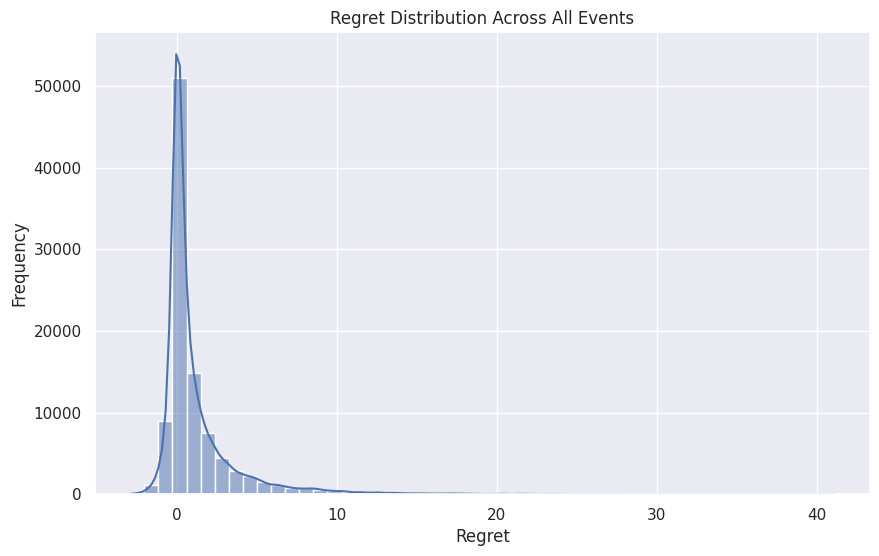

In [18]:
# visualize regret distribution if available (sample 100k rows if large)  
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])  
if 'regret' in cols:
    all_events = con.execute("SELECT grid_id, seed, regret FROM events LIMIT 100000").df()
    print('all_events shape:', all_events.shape)
    if sns is not None:
        plt.figure(figsize=(10,6))
        sns.histplot(all_events['regret'], bins=50, kde=True)
        plt.title('Regret Distribution Across All Events')
        plt.xlabel('Regret')
        plt.ylabel('Frequency')
        plt.show()
    else:
        plt.figure(figsize=(10,6))
        plt.hist(all_events['regret'], bins=50)
        plt.title('Regret Distribution Across All Events')
        plt.xlabel('Regret')
        plt.ylabel('Frequency')
        plt.show()

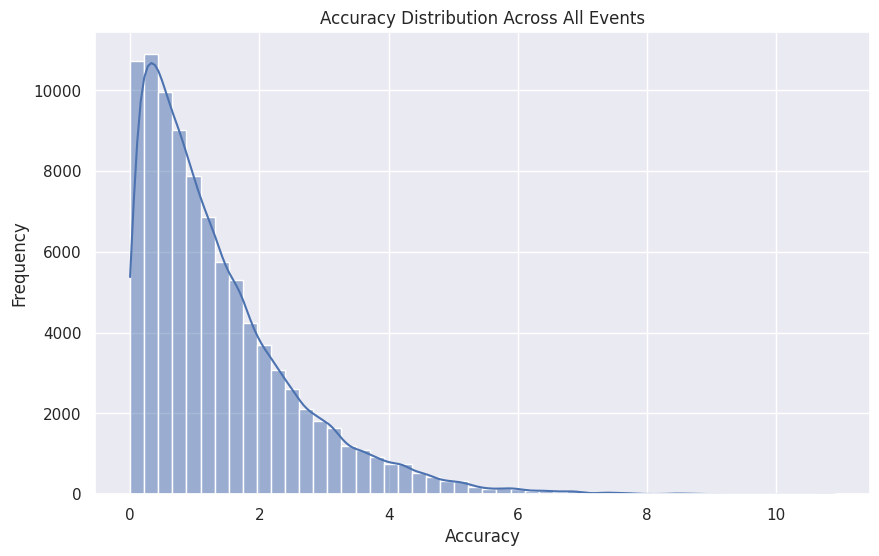

In [19]:
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
if 'acc' in cols:
    all_events = con.execute("SELECT grid_id, seed, acc FROM events LIMIT 100000").df()
    print('all_events shape:', all_events.shape)
    if sns is not None:
        plt.figure(figsize=(10,6))
        sns.histplot(all_events['acc'], bins=50, kde=True)
        plt.title('Accuracy Distribution Across All Events')
        plt.xlabel('Accuracy')
        plt.ylabel('Frequency')
        plt.show()
    else:
        plt.figure(figsize=(10,6))
        plt.hist(all_events['acc'], bins=50)
        plt.title('Accuracy Distribution Across All Events')
        plt.xlabel('Accuracy')
        plt.ylabel('Frequency')
        plt.show()

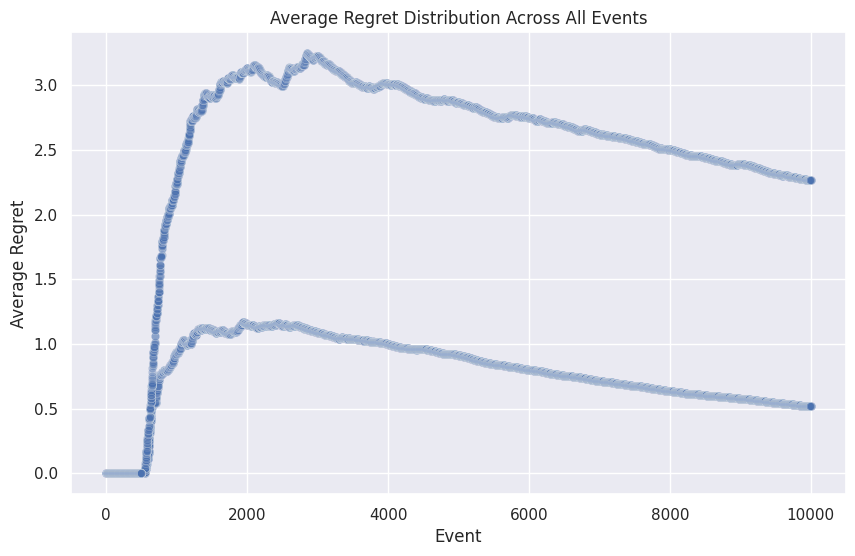

In [20]:
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
if 'avg_regret' in cols:
    all_events = con.execute("SELECT grid_id, seed, event, avg_regret FROM events LIMIT 100000").df()
    print('all_events shape:', all_events.shape)
    if sns is not None:
        plt.figure(figsize=(10,6))
        sns.scatterplot(data=all_events, x='event', y='avg_regret',alpha=0.1)
        plt.title('Average Regret Distribution Across All Events')
        plt.xlabel('Event')
        plt.ylabel('Average Regret')
        plt.show()
    else:
        plt.figure(figsize=(10,6))
        plt.hist(all_events['avg_regret'], bins=50)
        plt.title('Average Regret Distribution Across All Events')
        plt.xlabel('Average Regret')
        plt.ylabel('Frequency')
        plt.show()
        plt.title('Average Regret Distribution Across All Events')
        plt.xlabel('Average Regret')
        plt.ylabel('Frequency')
        plt.show()

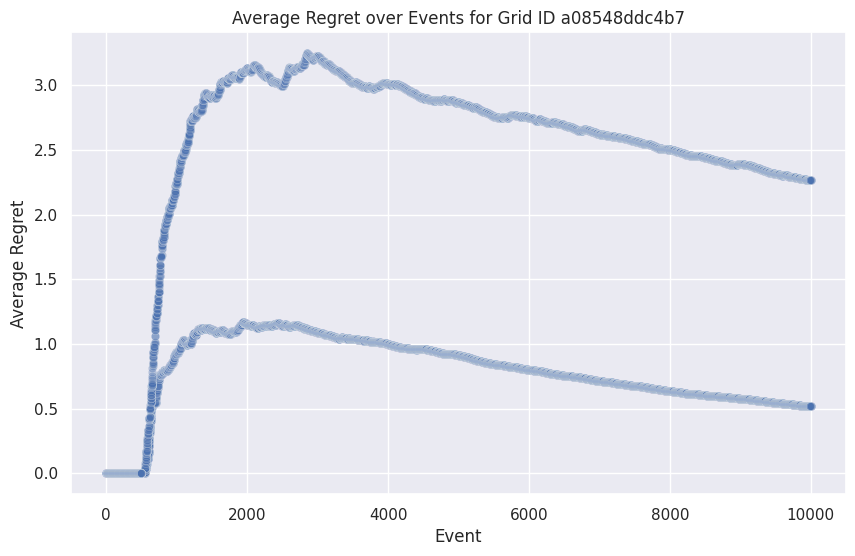

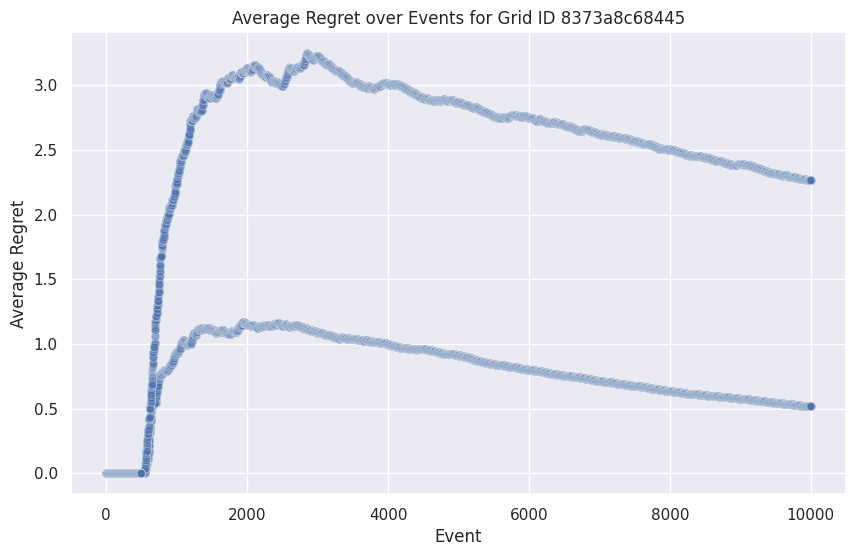

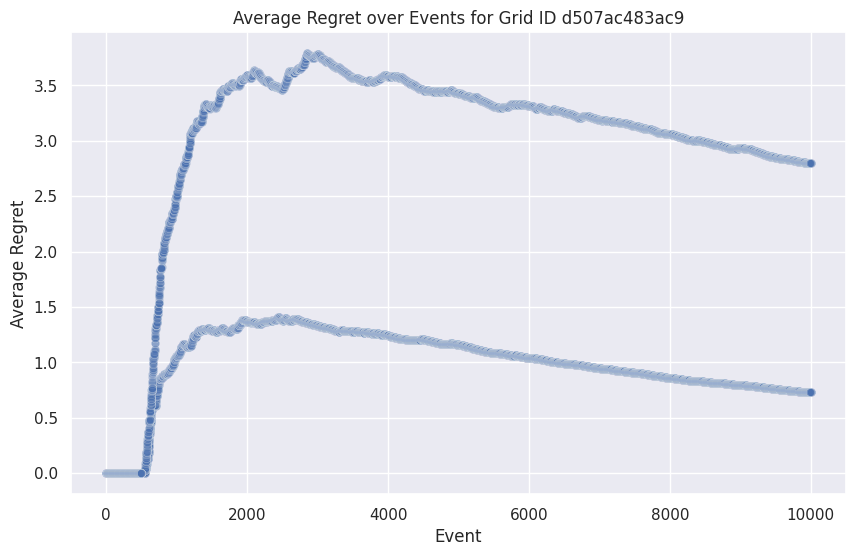

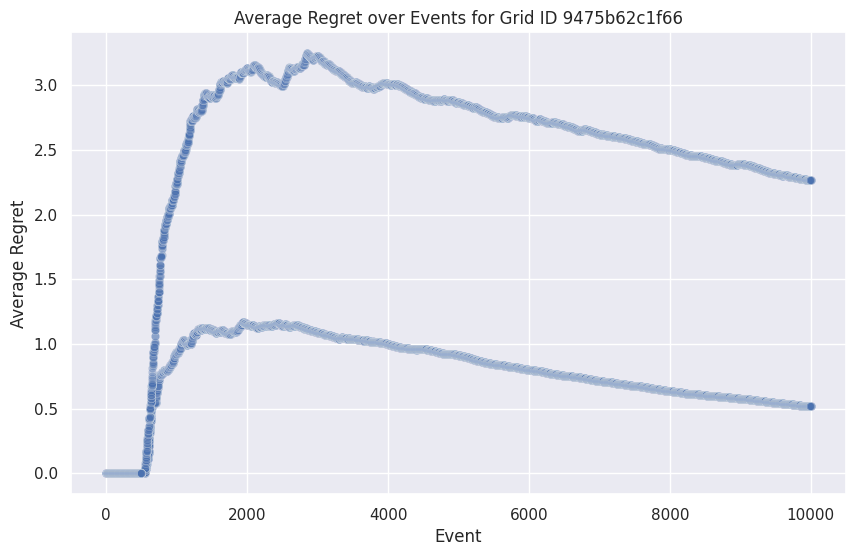

In [21]:
# plot one grid id per axis if regret and event columns exist
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
if 'avg_regret' in cols and 'event' in cols:
    sample_grid_ids = grid_summary['grid_id'].unique()[:4]  # Limit to first 4 grid_ids for clarity
    for gid in sample_grid_ids:
        grid_events = con.execute(f"SELECT event, avg_regret FROM events WHERE grid_id = '{gid}' LIMIT 100000").df()
        print(f'Grid ID: {gid}, shape: {grid_events.shape}')
        if sns is not None:
            plt.figure(figsize=(10,6))
            sns.scatterplot(data=grid_events, x='event', y='avg_regret', alpha=0.1)
            plt.title(f'Average Regret over Events for Grid ID {gid}')
            plt.xlabel('Event')
            plt.ylabel('Average Regret')
            plt.show()
        else:
            plt.figure(figsize=(10,6))
            plt.scatter(grid_events['event'], grid_events['avg_regret'], alpha=0.1)
            plt.title(f'Average Regret over Events for Grid ID {gid}')
            plt.xlabel('Event')
            plt.ylabel('Average Regret')
            plt.show()

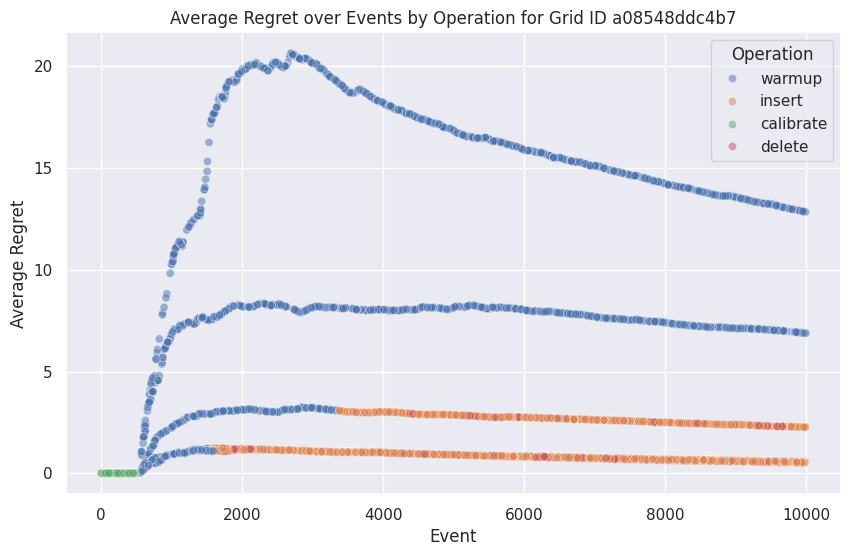

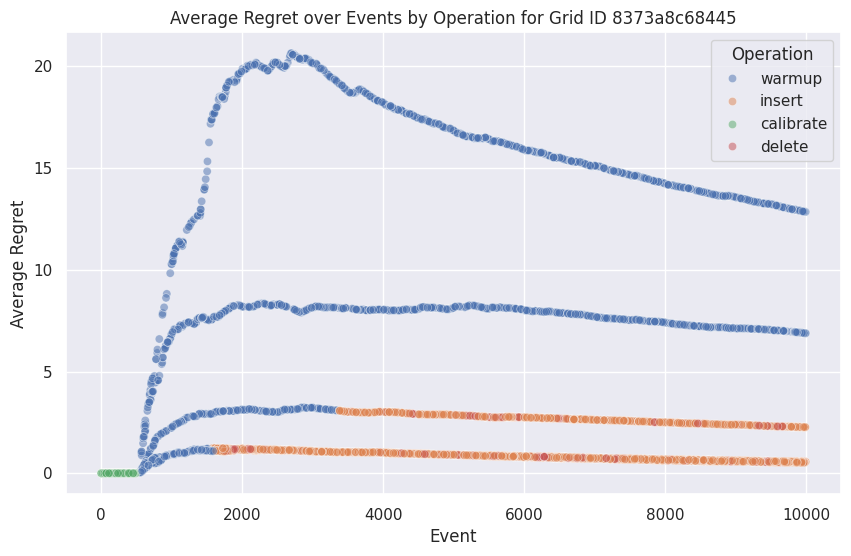

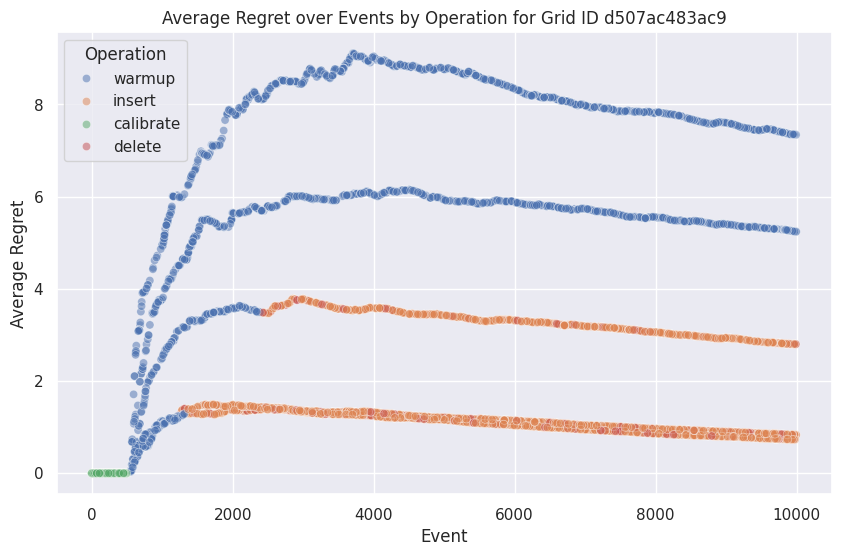

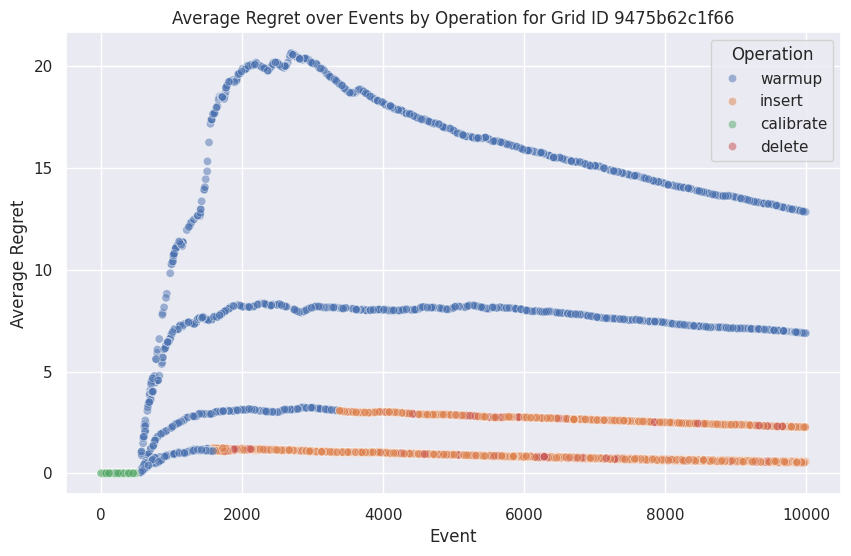

In [22]:
# plot one grid id per axis if regret and event columns exist with overlays for op type
# with only a sample of N = 1000 points per grid_id for clarity
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
if 'avg_regret' in cols and 'event' in cols and 'op' in cols:
    sample_grid_ids = grid_summary['grid_id'].unique()[:4]  # Limit to first 4 grid_ids for clarity
    for gid in sample_grid_ids:
        grid_events = con.execute(f"SELECT event, avg_regret, op FROM events WHERE grid_id = '{gid}'").df()
        grid_events = grid_events.sample(n=min(5000, len(grid_events)), random_state=42)
        print(f'Grid ID: {gid}, shape: {grid_events.shape}')
        if sns is not None:
            plt.figure(figsize=(10,6))
            sns.scatterplot(data=grid_events, x='event', y='avg_regret', hue='op', alpha=0.5)
            plt.title(f'Average Regret over Events by Operation for Grid ID {gid}')
            plt.xlabel('Event')
            plt.ylabel('Average Regret')
            plt.legend(title='Operation')
            plt.show()
        else:
            plt.figure(figsize=(10,6))
            for op_type in grid_events['op'].unique():
                subset = grid_events[grid_events['op'] == op_type]
                plt.scatter(subset['event'], subset['avg_regret'], alpha=0.5, label=op_type)
            plt.title(f'Average Regret over Events by Operation for Grid ID {gid}')
            plt.xlabel('Event')
            plt.ylabel('Average Regret')
            plt.legend(title='Operation')
            plt.show()

In [23]:
# Cleanup logging/tee for analysis notebook
def analysis_cleanup_logging():
    try:
        sys.stdout = ANALYSIS_ORIG_STDOUT
        sys.stderr = ANALYSIS_ORIG_STDERR
    except Exception:
        pass
    try:
        ANALYSIS_LOG_FP.flush()
        ANALYSIS_LOG_FP.close()
    except Exception:
        pass
    root = logging.getLogger()
    for h in list(root.handlers):
        try:
            root.removeHandler(h)
            h.flush()
            h.close()
        except Exception:
            pass
    print('Analysis logging cleaned up. Subsequent prints will not be teed.')

# Run this when finished to stop teeing and close log files
# analysis_cleanup_logging()